In [12]:
import awkward as ak
import numpy
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema, BaseSchema

fname = "/hdfs/store/user/kaho/NanoPost1/GluGlu_LFV_HToEMu_M125_TuneCP5_13TeV_PSweights_powheg_pythia8/GluGlu_LFV_HToEMu_M125/210728_002944/0000/tree_1.root"#/hdfs/store/user/kaho/NanoPost1/SingleMuon/SingleMuon_Run2017C-UL2017/210727_235847/0000/tree_50.root"
events = NanoEventsFactory.from_root(fname, schemaclass=NanoAODSchema).events()

/afs/hep.wisc.edu/user/kaho/NDHiggs/coffeaenv_local/lib64/python3.6/site-packages/coffea/nanoevents/schemas/nanoaod.py:202: RuntimeWarning: Missing cross-reference target for Electron_photonIdx => Photon
  RuntimeWarning,
/afs/hep.wisc.edu/user/kaho/NDHiggs/coffeaenv_local/lib64/python3.6/site-packages/coffea/nanoevents/schemas/nanoaod.py:195: RuntimeWarning: Missing cross-reference index for FatJet_genJetAK8Idx => GenJetAK8
  RuntimeWarning,
/afs/hep.wisc.edu/user/kaho/NDHiggs/coffeaenv_local/lib64/python3.6/site-packages/coffea/nanoevents/schemas/nanoaod.py:195: RuntimeWarning: Missing cross-reference index for FatJet_subJetIdx1 => SubJet
  RuntimeWarning,
/afs/hep.wisc.edu/user/kaho/NDHiggs/coffeaenv_local/lib64/python3.6/site-packages/coffea/nanoevents/schemas/nanoaod.py:195: RuntimeWarning: Missing cross-reference index for FatJet_subJetIdx2 => SubJet
  RuntimeWarning,
/afs/hep.wisc.edu/user/kaho/NDHiggs/coffeaenv_local/lib64/python3.6/site-packages/coffea/nanoevents/schemas/nanoa

In [13]:
#Choice em channel and Iso27
emevents = events[(events.channel == 0) & (events.HLT.IsoMu27 == 1)]

E_collections = emevents.Electron
M_collections = emevents.Muon

#Kinematics Selections
emevents["Electron", "Target"] = ((E_collections.pt > 24) & (abs(E_collections.eta) < 2.5) & (abs(E_collections.dxy) < 0.045) & (abs(E_collections.dz) < 0.2) & (E_collections.convVeto) & (E_collections.mvaFall17V2noIso_WP80) & (E_collections.miniPFRelIso_all < 0.1))
emevents["Muon", "Target"] = ((M_collections.pt > 29) & (abs(M_collections.eta) < 2.4) & (abs(M_collections.dxy) < 0.045) & (abs(M_collections.dz) < 0.2) & (M_collections.tightId) & (M_collections.pfRelIso04_all < 0.15))

E_collections = emevents.Electron[emevents.Electron.Target==1]
M_collections = emevents.Muon[emevents.Muon.Target==1]

#Opposite Charge
E_charge = ak.fill_none(ak.pad_none(E_collections.charge, 1), 0)
M_charge = ak.fill_none(ak.pad_none(M_collections.charge, 1), 0)
opp_charge = ak.flatten(E_charge*M_charge==-1)

emevents = emevents[opp_charge]

#Trig Matching
M_collections = emevents.Muon
trg_collections = emevents.TrigObj

M_collections = M_collections[M_collections.Target==1]
trg_collections = trg_collections[(((trg_collections.filterBits >> 1) & 1)==1) & (trg_collections.id == 13) & (trg_collections.pt > 29) & (ak.num(M_collections) == 1)]

trg_Match = ak.any((M_collections[:,0].delta_r(trg_collections) < 0.5),1)
emevents = emevents[trg_Match]

Electron_collections = emevents.Electron[emevents.Electron.Target==1]
Muon_collections = emevents.Muon[emevents.Muon.Target==1]
MET_collections = emevents.MET
Jet_collections = emevents.Jet[emevents.Jet.passJet30ID==1]
L_bJet_collections = emevents.Jet[emevents.Jet.passDeepJet_L==1]
M_bJet_collections = emevents.Jet[emevents.Jet.passDeepJet_M==1]

#ensure Jets are pT-ordered
Jet_collections = Jet_collections[ak.argsort(Jet_collections.pt_nom, axis=1, ascending=False)]
L_bJet_collections = L_bJet_collections[ak.argsort(L_bJet_collections.pt, axis=1, ascending=False)]
M_bJet_collections = M_bJet_collections[ak.argsort(M_bJet_collections.pt, axis=1, ascending=False)]

#Jet corrections
Jet_collections['pt'] = Jet_collections['pt_nom']
Jet_collections['mass'] = Jet_collections['mass_nom']

#MET pT corrections
MET_collections['phi'] = MET_collections['T1Smear_phi'] 
MET_collections['pt'] = MET_collections['T1Smear_pt'] \
                        - ak.flatten(Muon_collections['pt']) + ak.flatten(Muon_collections['corrected_pt'])\
                        - ak.flatten(Electron_collections['pt']/Electron_collections['eCorr'])\
                        + ak.flatten(Electron_collections['pt'])
                    
#Muon pT corrections
Muon_collections['pt'] = Muon_collections['corrected_pt']

#make interesting variables
Multijets_emevents = emevents[emevents.nJet30 > 1]
Multijets_emevents["mjj"] = (Jet_collections[emevents.nJet30 > 1][:,0] + Jet_collections[emevents.nJet30 > 1][:,1]).mass

#Get bTag SF
bTagSF_L = ak.prod(1-emevents.Jet.btagSF_deepjet_L*emevents.Jet.passDeepJet_L, axis=1)
bTagSF_M = ak.prod(1-emevents.Jet.btagSF_deepjet_M*emevents.Jet.passDeepJet_M, axis=1)

#PU/PF/Gen Weights
SF = emevents.puWeight*emevents.PrefireWeight*emevents.genWeight

#Muon SF
SF = SF*Muon_collections.Trigger_SF*Muon_collections.ID_SF*Muon_collections.ISO_SF

#Electron SF
SF = SF*Electron_collections.Reco_SF*Electron_collections.ID_SF

emu = Electron_collections[:,0] + Muon_collections[:,0]


In [40]:
#Write csv files
import pandas as pd
var_dict = {}
var_dict['mjj'] = ak.to_list(Multijets_emevents["mjj"])
var_dict['e_pt'] = ak.to_list(Multijets_emevents.Electron[Multijets_emevents.Electron.Target==1]["pt"][:,0])
df = pd.DataFrame(var_dict)
df.to_csv('out.csv')


In [4]:
del events
del emevents
del emu

In [6]:
from coffea import processor, hist
import numpy
class MyEMuPeak(processor.ProcessorABC):
    def __init__(self):
        self._histo = hist.Hist(
            "Events",
            hist.Cat("dataset", "samples"),
            hist.Bin("mass", "e_mu mass", 50, 110, 160),
        )

    @property
    def accumulator(self):
        return self._histo
    
    def Vetos(self, events):
        #Choice em channel and Iso27
        emevents = events[(events.channel == 0) & (events.HLT.IsoMu27 == 1)]

        E_collections = emevents.Electron
        M_collections = emevents.Muon

        #Kinematics Selections
        emevents["Electron", "Target"] = ((E_collections.pt > 24) & (abs(E_collections.eta) < 2.5) & (abs(E_collections.dxy) < 0.045) & (abs(E_collections.dz) < 0.2) & (E_collections.convVeto) & (E_collections.mvaFall17V2noIso_WP80) & (E_collections.miniPFRelIso_all < 0.1))
        emevents["Muon", "Target"] = ((M_collections.pt > 29) & (abs(M_collections.eta) < 2.4) & (abs(M_collections.dxy) < 0.045) & (abs(M_collections.dz) < 0.2) & (M_collections.tightId) & (M_collections.pfRelIso04_all < 0.15))

        E_collections = emevents.Electron[emevents.Electron.Target==1]
        M_collections = emevents.Muon[emevents.Muon.Target==1]

        #Opposite Charge
        E_charge = ak.fill_none(ak.pad_none(E_collections.charge, 1), 0)
        M_charge = ak.fill_none(ak.pad_none(M_collections.charge, 1), 0)
        opp_charge = ak.flatten(E_charge*M_charge==-1)

        emevents = emevents[opp_charge]

        #Trig Matching
        M_collections = emevents.Muon
        trg_collections = emevents.TrigObj

        M_collections = M_collections[M_collections.Target==1]
        trg_collections = trg_collections[(((trg_collections.filterBits >> 1) & 1)==1) & (trg_collections.id == 13) & (trg_collections.pt > 29) & (ak.num(M_collections) == 1)]

        trg_Match = ak.any((M_collections[:,0].delta_r(trg_collections) < 0.5),1)

        return emevents[trg_Match]
    
    def SF(self, emevents):
        #Get bTag SF
        bTagSF_L = ak.prod(1-emevents.Jet.btagSF_deepjet_L*emevents.Jet.passDeepJet_L, axis=1)
        bTagSF_M = ak.prod(1-emevents.Jet.btagSF_deepjet_M*emevents.Jet.passDeepJet_M, axis=1)

        #PU/PF/Gen Weights
        SF = emevents.puWeight*emevents.PrefireWeight*emevents.genWeight

        Muon_collections = emevents.Muon[emevents.Muon.Target==1]
        Electron_collections = emevents.Electron[emevents.Electron.Target==1]
        
        #Muon SF
        SF = SF*Muon_collections.Trigger_SF*Muon_collections.ID_SF*Muon_collections.ISO_SF

        #Electron SF
        SF = SF*Electron_collections.Reco_SF*Electron_collections.ID_SF
        
        return ak.flatten(SF)
        
    # we will receive a NanoEvents instead of a coffea DataFrame
    def process(self, events):
        out = self.accumulator.identity()
        emevents = self.Vetos(events)
        emu = emevents.Muon[:,0] + emevents.Electron[:,0]
        weight = self.SF(emevents)
        out.fill(
            dataset=events.metadata["dataset"],
            mass=emu.mass, #emuevents.emMass,
            weight=weight
        )
        return out

    def postprocess(self, accumulator):
        return accumulator

In [7]:
import glob
import os
import time
ncpu = os.cpu_count()
print ("Number of cores: %i"%ncpu)
fsetGG = glob.glob('/hdfs/store/user/kaho/NanoPost1/GluGlu_LFV_HToEMu_M125_TuneCP5_13TeV_PSweights_powheg_pythia8/*/*/*/*root')
fsetSigMu = glob.glob('/hdfs/store/user/kaho/NanoPost1/SingleMuon/*/*/*/*root')

samples = {
    "GGToEMu": fsetGG,
    #"Single Mu": fsetSigMu
}

t1_start = time.time()
result = processor.run_uproot_job(
    samples,
    "Events",
    MyEMuPeak(),
    processor.futures_executor,
    {"schema": NanoAODSchema, "workers": os.cpu_count()},
)
t1_stop = time.time()
print("Elapsed time:", t1_stop-t1_start)

Number of cores: 24


Processing:   0%|          | 0/7 [00:00<?, ?chunk/s]

/afs/hep.wisc.edu/user/kaho/NDHiggs/coffeaenv_local/lib64/python3.6/site-packages/coffea/nanoevents/schemas/nanoaod.py:202: RuntimeWarning: Missing cross-reference target for Electron_photonIdx => Photon
  RuntimeWarning,
/afs/hep.wisc.edu/user/kaho/NDHiggs/coffeaenv_local/lib64/python3.6/site-packages/coffea/nanoevents/schemas/nanoaod.py:195: RuntimeWarning: Missing cross-reference index for FatJet_genJetAK8Idx => GenJetAK8
  RuntimeWarning,
/afs/hep.wisc.edu/user/kaho/NDHiggs/coffeaenv_local/lib64/python3.6/site-packages/coffea/nanoevents/schemas/nanoaod.py:195: RuntimeWarning: Missing cross-reference index for FatJet_subJetIdx1 => SubJet
  RuntimeWarning,
/afs/hep.wisc.edu/user/kaho/NDHiggs/coffeaenv_local/lib64/python3.6/site-packages/coffea/nanoevents/schemas/nanoaod.py:195: RuntimeWarning: Missing cross-reference index for FatJet_subJetIdx2 => SubJet
  RuntimeWarning,
/afs/hep.wisc.edu/user/kaho/NDHiggs/coffeaenv_local/lib64/python3.6/site-packages/coffea/nanoevents/schemas/nanoa

/afs/hep.wisc.edu/user/kaho/NDHiggs/coffeaenv_local/lib64/python3.6/site-packages/coffea/nanoevents/schemas/nanoaod.py:195: RuntimeWarning: Missing cross-reference index for Tau_jetIdx => Jet
  RuntimeWarning,
/afs/hep.wisc.edu/user/kaho/NDHiggs/coffeaenv_local/lib64/python3.6/site-packages/coffea/nanoevents/schemas/nanoaod.py:202: RuntimeWarning: Missing cross-reference target for Electron_photonIdx => Photon
  RuntimeWarning,
/afs/hep.wisc.edu/user/kaho/NDHiggs/coffeaenv_local/lib64/python3.6/site-packages/coffea/nanoevents/schemas/nanoaod.py:195: RuntimeWarning: Missing cross-reference index for FatJet_genJetAK8Idx => GenJetAK8
  RuntimeWarning,
/afs/hep.wisc.edu/user/kaho/NDHiggs/coffeaenv_local/lib64/python3.6/site-packages/coffea/nanoevents/schemas/nanoaod.py:195: RuntimeWarning: Missing cross-reference index for FatJet_subJetIdx1 => SubJet
  RuntimeWarning,
/afs/hep.wisc.edu/user/kaho/NDHiggs/coffeaenv_local/lib64/python3.6/site-packages/coffea/nanoevents/schemas/nanoaod.py:195:

/afs/hep.wisc.edu/user/kaho/NDHiggs/coffeaenv_local/lib64/python3.6/site-packages/coffea/nanoevents/schemas/nanoaod.py:195: RuntimeWarning: Missing cross-reference index for Photon_electronIdx => Electron
  RuntimeWarning,
/afs/hep.wisc.edu/user/kaho/NDHiggs/coffeaenv_local/lib64/python3.6/site-packages/coffea/nanoevents/schemas/nanoaod.py:195: RuntimeWarning: Missing cross-reference index for FatJet_subJetIdx2 => SubJet
  RuntimeWarning,
/afs/hep.wisc.edu/user/kaho/NDHiggs/coffeaenv_local/lib64/python3.6/site-packages/coffea/nanoevents/schemas/nanoaod.py:195: RuntimeWarning: Missing cross-reference index for Photon_genPartIdx => GenPart
  RuntimeWarning,
/afs/hep.wisc.edu/user/kaho/NDHiggs/coffeaenv_local/lib64/python3.6/site-packages/coffea/nanoevents/schemas/nanoaod.py:195: RuntimeWarning: Missing cross-reference index for FsrPhoton_muonIdx => Muon
  RuntimeWarning,
/afs/hep.wisc.edu/user/kaho/NDHiggs/coffeaenv_local/lib64/python3.6/site-packages/coffea/nanoevents/schemas/nanoaod.py

Elapsed time: 4.746060848236084


In [9]:
from coffea.util import save, load
save(hist, "output.coffea")

<AxesSubplot:xlabel='e_mu mass', ylabel='Events'>

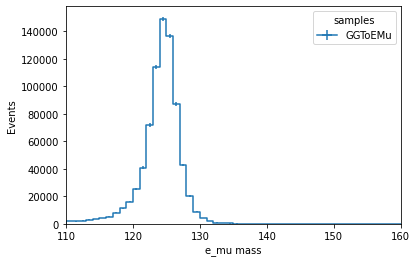

In [10]:
hist = load("output.coffea")

%matplotlib inline

hist.plot1d(result)

In [7]:
import uproot3
fout = uproot3.recreate('output.root')
a = result['GGToEMu'].to_boost()
b = (a.to_numpy()[0][0], a.to_numpy()[-1])
fout['GGToEMu'] = b
#fout['Single Mu'].show()
fout.close()

In [8]:
fout = uproot3.open('output.root')
fout['GGToEMu'].show()
fout.close()

                       0                                              1.5648e+05
                       +-------------------------------------------------------+
[-inf, 110) 0          |                                                       |
[110, 111)  1928.5     |*                                                      |
[111, 112)  1770.7     |*                                                      |
[112, 113)  2224       |*                                                      |
[113, 114)  2918.5     |*                                                      |
[114, 115)  3505.2     |*                                                      |
[115, 116)  4196.7     |*                                                      |
[116, 117)  5277.2     |**                                                     |
[117, 118)  8161.5     |***                                                    |
[118, 119)  11166      |****                                                   |
[119, 120)  16164      |****